In [1]:
%env CUDA_VISIBLE_DEVICES=-1
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

env: CUDA_VISIBLE_DEVICES=-1


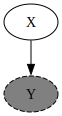

In [2]:
def model():
    X = pyro.sample("X", dist.Bernoulli(0.5))
    # Y = pyro.sample("Y", dist.Delta(X))
    Y = pyro.deterministic("Y", X, event_dim=0)

    return {"X": X, "Y": Y}

with ExtractSupports() as extract_supports:
    model()
    supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(model)

The output of the following two cells should be same. If this is a feature and not a bug, then we should take that into account while processing traces in explanability module.

In [3]:
pyro.clear_param_store()
conditioned_model = condition(data={"X": torch.tensor(1.0)})(model)

guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(conditioned_model)

log_weights, trace, _ = pyro.infer.importance.vectorized_importance_weights(conditioned_model, guide, num_samples = 10, max_plate_nesting=3, normalized = False)

print(log_weights)
print(trace.nodes["X"]["value"].squeeze(), trace.nodes["X"]["log_prob"].squeeze())
print(trace.nodes["Y"]["value"].squeeze(), trace.nodes["Y"]["log_prob"].squeeze())
print(torch.exp(torch.logsumexp(log_weights, dim=0) - math.log(10)))

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])
tensor(1.) tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])
tensor(1.) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.5000)


In [4]:
pyro.clear_param_store()
conditioned_model = condition(data={"Y": torch.tensor(1.0)})(model)

guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(conditioned_model)

log_weights, trace, _ = pyro.infer.importance.vectorized_importance_weights(conditioned_model, guide, num_samples = 10, max_plate_nesting=3, normalized = False)

print(log_weights)
print(trace.nodes["X"]["value"].squeeze(), trace.nodes["X"]["log_prob"].squeeze())
print(trace.nodes["Y"]["value"], trace.nodes["Y"]["log_prob"].squeeze())
print(torch.exp(torch.logsumexp(log_weights, dim=0) - math.log(10)))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0.]) tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])
tensor(1.) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.)
